<a href="https://colab.research.google.com/github/GayaneYemishyan/air-quality-clustering/blob/main/air_quality_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrating API

In [4]:
import requests

In [5]:
url = "https://emvnh9buoh.execute-api.us-east-1.amazonaws.com/getData?device_id=8&start_time=2025-09-01&end_time=2025-12-01"

params = {
    "city": "Yerevan",
    "start_date": "2025-09-01",
    "end_date": "2025-12-01",
    "resolution": "hourly",
    "format": "json",
    "parameters": [
        "temperature",
        "pressure",
        "humidity",
        "pm1",
        "pm2_5",
        "pm10",
        "wind_speed",
        "wind_direction",
        "rain"
    ]
}

response = requests.get(url, params=params)
data = response.json()

print(data["keys"])
print(len(data["data"]))


['id', 'timestamp', 'uv', 'lux', 'temperature', 'pressure', 'humidity', 'pm1', 'pm2_5', 'pm10', 'wind speed', 'rain', 'wind direction']
8777


# Data cleaning

In [6]:
import pandas as pd
df = pd.DataFrame(data['data'], columns=data['keys'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8777 entries, 0 to 8776
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8777 non-null   int64  
 1   timestamp       8777 non-null   object 
 2   uv              6615 non-null   float64
 3   lux             8777 non-null   float64
 4   temperature     8777 non-null   float64
 5   pressure        8777 non-null   int64  
 6   humidity        8777 non-null   int64  
 7   pm1             8777 non-null   int64  
 8   pm2_5           8777 non-null   int64  
 9   pm10            8777 non-null   int64  
 10  wind speed      8777 non-null   float64
 11  rain            8777 non-null   float64
 12  wind direction  8402 non-null   object 
dtypes: float64(5), int64(6), object(2)
memory usage: 891.5+ KB


In [8]:
# Check missing values percentage
missing_pct = round(df.isnull().sum()/len(df) * 100, 1)
print(missing_pct)

id                 0.0
timestamp          0.0
uv                24.6
lux                0.0
temperature        0.0
pressure           0.0
humidity           0.0
pm1                0.0
pm2_5              0.0
pm10               0.0
wind speed         0.0
rain               0.0
wind direction     4.3
dtype: float64


In [9]:
# Fill missing 'uv' with mode
df['uv'] = df['uv'].fillna(df['uv'].mode()[0])
# Fill missing 'wind direction' with mode
df['wind direction'] = df['wind direction'].fillna(df['wind direction'].mode()[0])

In [10]:
df.drop(df[(df['pm1'] == 0) & (df['pm2_5'] == 0) & (df['pm10'] == 0)].index, inplace=True)

In [11]:
df.duplicated().sum() #Checking if there are duplicates
#There are no dupicates

np.int64(0)

In [12]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, 0 to 8776
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              6400 non-null   int64  
 1   timestamp       6400 non-null   object 
 2   uv              6400 non-null   float64
 3   lux             6400 non-null   float64
 4   temperature     6400 non-null   float64
 5   pressure        6400 non-null   int64  
 6   humidity        6400 non-null   int64  
 7   pm1             6400 non-null   int64  
 8   pm2_5           6400 non-null   int64  
 9   pm10            6400 non-null   int64  
 10  wind speed      6400 non-null   float64
 11  rain            6400 non-null   float64
 12  wind direction  6400 non-null   object 
dtypes: float64(5), int64(6), object(2)
memory usage: 700.0+ KB
None
      id            timestamp   uv      lux  temperature  pressure  humidity  \
0  56790  2025-10-17 16:15:00  3.0  41593.0        21.08       874        

# Data Preprocessing

In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['wind direction'] = df['wind direction'].astype('category')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, 0 to 8776
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              6400 non-null   int64         
 1   timestamp       6400 non-null   datetime64[ns]
 2   uv              6400 non-null   float64       
 3   lux             6400 non-null   float64       
 4   temperature     6400 non-null   float64       
 5   pressure        6400 non-null   int64         
 6   humidity        6400 non-null   int64         
 7   pm1             6400 non-null   int64         
 8   pm2_5           6400 non-null   int64         
 9   pm10            6400 non-null   int64         
 10  wind speed      6400 non-null   float64       
 11  rain            6400 non-null   float64       
 12  wind direction  6400 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(5), int64(6)
memory usage: 656.6 KB
None


In [14]:
direction_to_deg = {
    "N": 0, "NE": 45, "E": 90, "SE": 135,
    "S": 180, "SW": 225, "W": 270, "NW": 315
}

df["wind_dir_deg"] = df["wind direction"].map(direction_to_deg)


In [15]:
import numpy as np
df["wind_dir_deg"] = df["wind_dir_deg"].astype(float)
df["wind_dir_sin"] = np.sin(np.deg2rad(df["wind_dir_deg"]))
df["wind_dir_cos"] = np.cos(np.deg2rad(df["wind_dir_deg"]))

In [17]:
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['dayofyear'] = df['timestamp'].dt.dayofyear
df['month'] = df['timestamp'].dt.month
print(df[['timestamp', 'hour', 'dayofweek', 'dayofyear', 'month']].head())

            timestamp  hour  dayofweek  dayofyear  month
0 2025-10-17 16:15:00    16          4        290     10
1 2025-10-17 16:30:00    16          4        290     10
2 2025-10-17 16:45:00    16          4        290     10
3 2025-10-17 17:00:00    17          4        290     10
4 2025-10-17 17:15:00    17          4        290     10


In [18]:
df.drop('id', axis=1, inplace=True)
df.drop(['wind direction', 'wind_dir_deg'], axis=1, inplace=True)
print(df.head())
print(df.info())

            timestamp   uv      lux  temperature  pressure  humidity  pm1  \
0 2025-10-17 16:15:00  3.0  41593.0        21.08       874        35   10   
1 2025-10-17 16:30:00  3.0  26926.0        19.53       874        38    9   
2 2025-10-17 16:45:00  3.0  12327.0        17.87       874        42   10   
3 2025-10-17 17:00:00  3.0  13404.0        17.91       874        42   10   
4 2025-10-17 17:15:00  2.0   9302.0        17.37       874        43   10   

   pm2_5  pm10  wind speed  rain  wind_dir_sin  wind_dir_cos  hour  dayofweek  \
0     11    12        0.61   0.0 -1.000000e+00 -1.836970e-16    16          4   
1      9     9        0.71   0.0  7.071068e-01  7.071068e-01    16          4   
2     10    10        0.37   0.0  1.224647e-16 -1.000000e+00    16          4   
3     10    11        0.35   0.0 -7.071068e-01  7.071068e-01    17          4   
4     11    11        0.49   0.0  1.224647e-16 -1.000000e+00    17          4   

   dayofyear  month  
0        290     10  
1     

In [19]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns to be scaled
numerical_cols = ['uv', 'lux', 'temperature', 'pressure', 'humidity', 'pm1', 'pm2_5', 'pm10', 'wind speed', 'rain', 'wind_dir_sin', 'wind_dir_cos']

# Instantiate StandardScaler
scaler = StandardScaler()

# Apply fit_transform to the selected numerical columns and overwrite them
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display the head of the DataFrame to verify the scaling
print(df[numerical_cols].head())

         uv       lux  temperature  pressure  humidity       pm1     pm2_5  \
0  1.209875  1.502067     0.794951  0.703322 -0.822059 -0.491007 -0.493269   
1  1.209875  0.746407     0.590864  0.703322 -0.665670 -0.515035 -0.533503   
2  1.209875 -0.005750     0.372294  0.703322 -0.457152 -0.491007 -0.513386   
3  1.209875  0.049738     0.377560  0.703322 -0.457152 -0.491007 -0.513386   
4  0.641275 -0.161602     0.306459  0.703322 -0.405022 -0.491007 -0.493269   

       pm10  wind speed      rain  wind_dir_sin  wind_dir_cos  
0 -0.485890   -0.193468 -0.053738     -1.684410     -0.839064  
1 -0.538576   -0.017074 -0.053738      0.805454      0.458638  
2 -0.521014   -0.616812 -0.053738     -0.225881     -2.674292  
3 -0.503452   -0.652091 -0.053738     -1.257217      0.458638  
4 -0.503452   -0.405140 -0.053738     -0.225881     -2.674292  


# Data Analysis and Visualization

In [56]:
import pandas as pd
import numpy as np

df_eda = pd.DataFrame(data['data'], columns=data['keys'])

# Fill missing 'uv' with mode
df_eda['uv'] = df_eda['uv'].fillna(df_eda['uv'].mode()[0])
# Fill missing 'wind direction' with mode
df_eda['wind direction'] = df_eda['wind direction'].fillna(df_eda['wind direction'].mode()[0])


# Apply preprocessing steps
df_eda['timestamp'] = pd.to_datetime(df_eda['timestamp'])
df_eda['wind direction'] = df_eda['wind direction'].astype('category')

direction_to_deg = {
    "N": 0, "NE": 45, "E": 90, "SE": 135,
    "S": 180, "SW": 225, "W": 270, "NW": 315
}

df_eda["wind_dir_deg"] = df_eda["wind direction"].map(direction_to_deg)
df_eda["wind_dir_deg"] = df_eda["wind_dir_deg"].astype(float)
df_eda["wind_dir_sin"] = np.sin(np.deg2rad(df_eda["wind_dir_deg"]))
df_eda["wind_dir_cos"] = np.cos(np.deg2rad(df_eda["wind_dir_deg"]))

df_eda['hour'] = df_eda['timestamp'].dt.hour
df_eda['dayofweek'] = df_eda['timestamp'].dt.dayofweek
df_eda['dayofyear'] = df_eda['timestamp'].dt.dayofyear
df_eda['month'] = df_eda['timestamp'].dt.month

df_eda.drop('id', axis=1, inplace=True)
df_eda.drop(['wind direction', 'wind_dir_deg'], axis=1, inplace=True)

In [53]:
df_eda.describe()

,timestamp,uv,lux,temperature,pressure,humidity,pm1,pm2_5,pm10,wind speed,rain,wind_dir_sin,wind_dir_cos,hour,dayofweek,dayofyear,month
count,8777,8777.000000,8777.000000,8777.000000,8777.000000,8777.000000,8777.000000,8777.000000,8777.000000,8777.000000,8777.000000,8777.000000,8.777000e+03,8777.000000,8777.000000,8777.000000,8777.000000
mean,2025-10-17 00:55:18.115870976,0.884243,12008.419733,14.077267,871.612054,52.259998,22.192777,25.900308,28.924348,0.676669,0.005133,0.170852,4.508944e-01,11.497892,2.973453,289.543694,10.022559
min,2025-09-01 00:00:00,0.000000,5.000000,0.130000,861.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000e+00,0.000000,0.000000,244.000000,9.000000
25%,2025-09-23 21:15:00,0.000000,6.000000,9.050000,868.000000,39.000000,0.000000,0.000000,0.000000,0.250000,0.000000,-0.707107,6.123234e-17,5.000000,1.000000,266.000000,9.000000
50%,2025-10-17 02:45:00,0.000000,9.000000,13.070000,871.000000,51.000000,7.000000,8.000000,9.000000,0.590000,0.000000,0.707107,7.071068e-01,11.000000,3.000000,290.000000,10.000000
75%,2025-11-09 02:45:00,1.000000,13377.000000,18.330000,875.000000,62.000000,15.000000,17.000000,18.000000,0.980000,0.000000,0.707107,7.071068e-01,18.000000,5.000000,313.000000,11.000000
max,2025-12-02 00:00:00,7.000000,52428.000000,38.120000,883.000000,100.000000,304.000000,356.000000,399.000000,5.120000,3.350000,1.000000,1.000000e+00,23.000000,6.000000,336.000000,12.000000
std,NaN,1.677862,19129.711192,6.996596,4.332601,18.623454,38.028131,45.289776,51.722554,0.544191,0.079516,0.687895,5.425791e-01,6.940398,2.009175,26.621224,0.836002


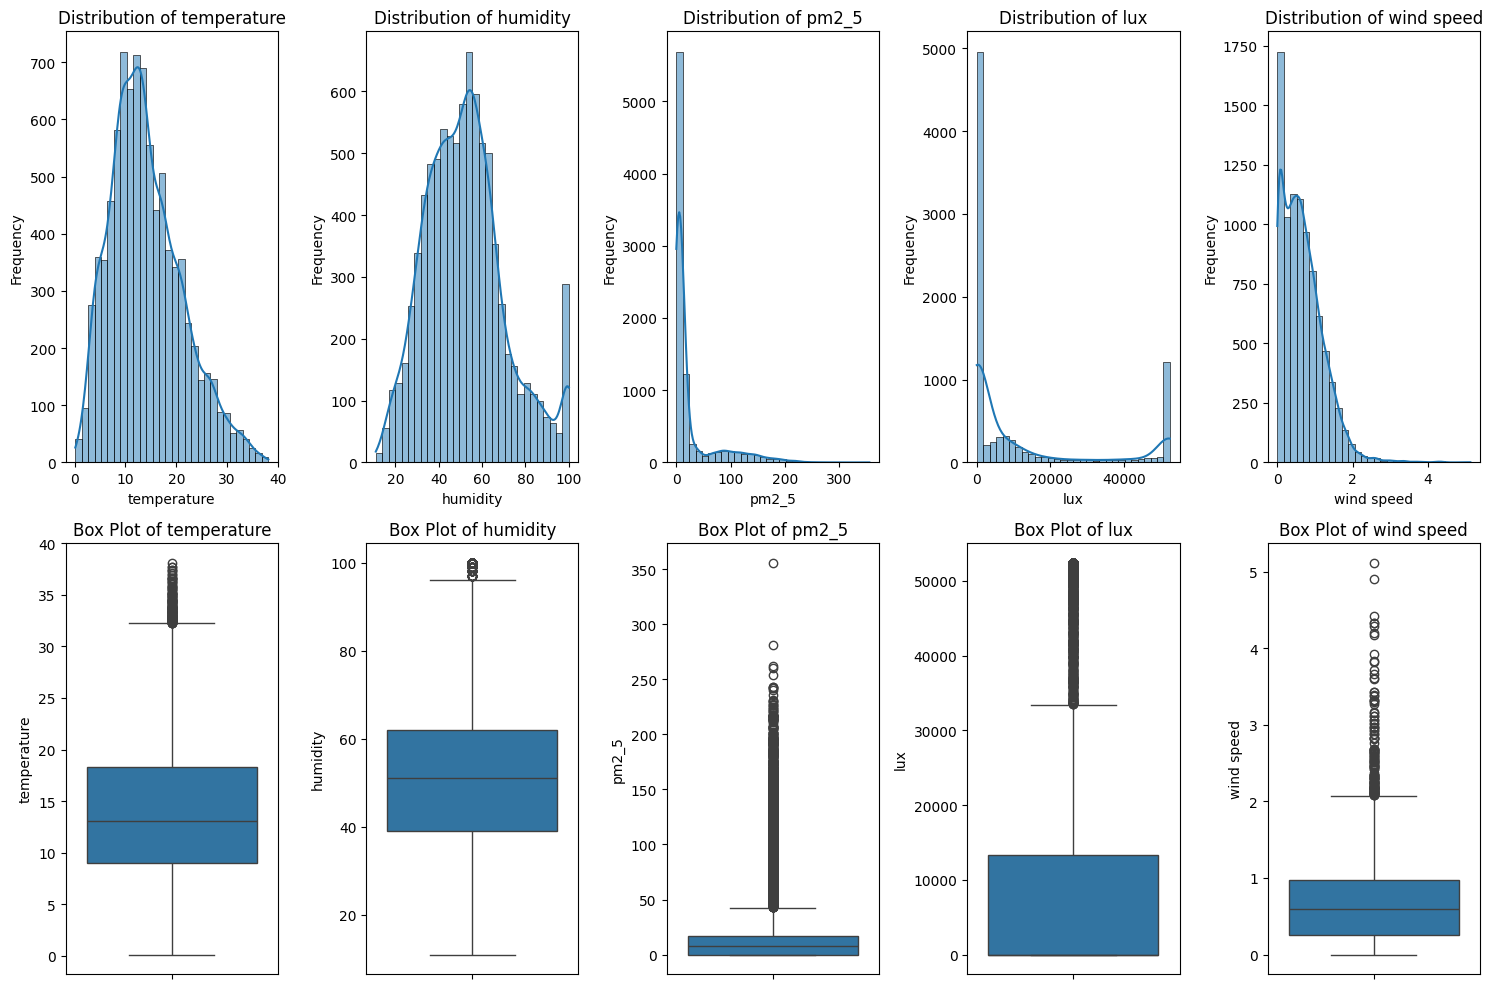

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = ['temperature', 'humidity', 'pm2_5', 'lux', 'wind speed']

# Create a figure with subplots
plt.figure(figsize=(15, 10)) # Adjust figure size as needed

for i, feature in enumerate(features_to_plot):
    # Histogram subplot
    plt.subplot(2, len(features_to_plot), i + 1) # 2 rows for hist and box plots
    sns.histplot(df_eda[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Box plot subplot
    plt.subplot(2, len(features_to_plot), i + 1 + len(features_to_plot))
    sns.boxplot(y=df_eda[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

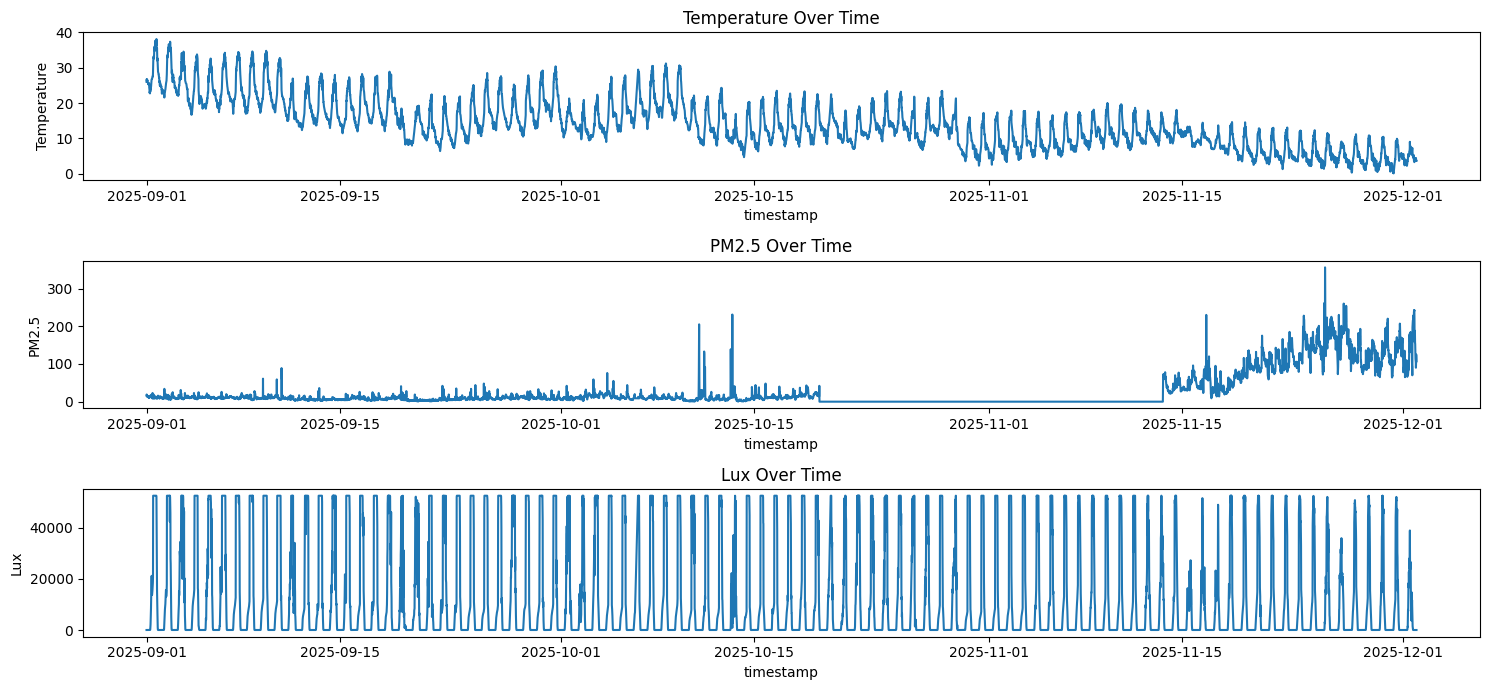

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 7))

plt.subplot(3, 1, 1) # 3 rows, 1 column, 1st plot
sns.lineplot(x='timestamp', y='temperature', data=df_eda)
plt.title('Temperature Over Time')
plt.ylabel('Temperature')

plt.subplot(3, 1, 2) # 3 rows, 1 column, 2nd plot
sns.lineplot(x='timestamp', y='pm2_5', data=df_eda)
plt.title('PM2.5 Over Time')
plt.ylabel('PM2.5')

plt.subplot(3, 1, 3) # 3 rows, 1 column, 3rd plot
sns.lineplot(x='timestamp', y='lux', data=df_eda)
plt.title('Lux Over Time')
plt.ylabel('Lux')

plt.tight_layout()
plt.show()

In [23]:
numerical_cols_for_corr = df_eda.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()
# Exclude 'timestamp' if it somehow ends up in numerical (e.g., if it wasn't converted to datetime properly earlier)
if 'timestamp' in numerical_cols_for_corr:
    numerical_cols_for_corr.remove('timestamp')

# Compute the correlation matrix
corr_matrix = df_eda[numerical_cols_for_corr].corr()

print("Correlation Matrix Head:")
print(corr_matrix.head())

Correlation Matrix Head:
                   uv       lux  temperature  pressure  humidity       pm1  \
uv           1.000000  0.668102     0.464713 -0.154550 -0.370574 -0.060973   
lux          0.668102  1.000000     0.531532 -0.088497 -0.466219 -0.107439   
temperature  0.464713  0.531532     1.000000 -0.669337 -0.741139 -0.602045   
pressure    -0.154550 -0.088497    -0.669337  1.000000  0.502572  0.496619   
humidity    -0.370574 -0.466219    -0.741139  0.502572  1.000000  0.261540   

                pm2_5      pm10  wind speed      rain  wind_dir_sin  \
uv          -0.066020 -0.070478    0.123806 -0.005233     -0.294074   
lux         -0.112905 -0.117863    0.106312 -0.025137     -0.364407   
temperature -0.605771 -0.607676    0.294283 -0.038583     -0.260342   
pressure     0.490573  0.483265   -0.267224 -0.043221      0.124196   
humidity     0.262953  0.263580   -0.263318  0.127691      0.191631   

             wind_dir_cos      hour  dayofweek  dayofyear     month  
uv       

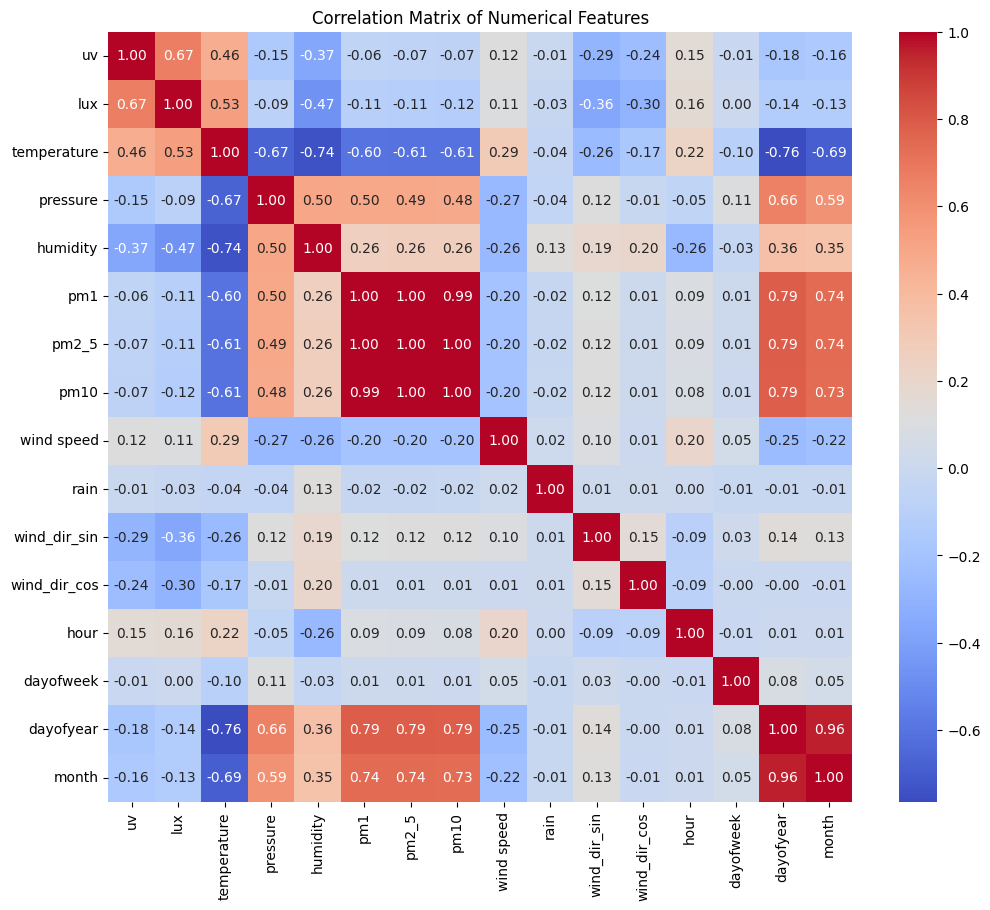

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 5. Clustering Models

After exploring and visualizing the air quality data, we apply unsupervised learning techniques to identify natural patterns in environmental conditions.
The objective of clustering is to group observations with similar air quality characteristics without using predefined labels.

In this section, multiple clustering algorithms are implemented and compared.
All models are trained using standardized air quality features to ensure fair comparison.


tep 1: Feature Selection for Clustering (CODE)

In [25]:
# Select air-quality related features for clustering
cluster_features = [
    'temperature',
    'pressure',
    'humidity',
    'pm1',
    'pm2_5',
    'pm10',
    'wind speed',
    'rain',
    'uv',
    'lux',
    'wind_dir_sin',
    'wind_dir_cos'
]

X = df[cluster_features]
print(X.shape)


(6400, 12)



### 5.1 K-Means Clustering

K-Means is a centroid-based clustering algorithm that partitions data into a predefined number of clusters by minimizing the within-cluster variance.
It is used as a baseline model due to its simplicity and interpretability.


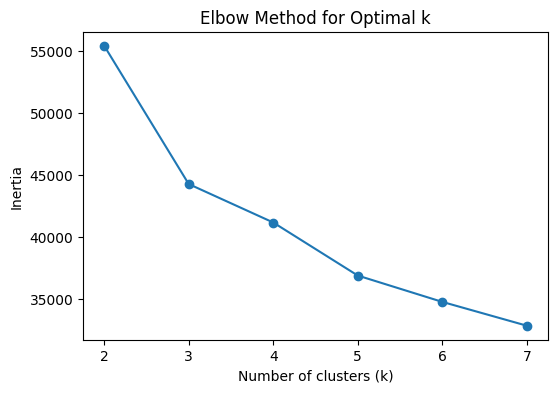

In [26]:
#Choosing Number of Clusters (Elbow Method)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 8)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [27]:
# Train K-Means with selected number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Add cluster labels to dataframe
df['kmeans_cluster'] = kmeans_labels


In [28]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_db = davies_bouldin_score(X, kmeans_labels)

print("K-Means Silhouette Score:",
      kmeans_silhouette)

print("K-Means Davies-Bouldin Index:",
      kmeans_db)

K-Means Silhouette Score: 0.31017809007960134
K-Means Davies-Bouldin Index: 1.3056462570493188


### Dimensionality Reduction with PCA

The air quality dataset contains many numerical features, making it difficult to visualize clusters directly in high-dimensional space. To address this, Principal Component Analysis (PCA) was applied to reduce the dataset to two principal components while retaining most of the variance. This transformation allows us to plot the clusters in 2D, making it easier to interpret and compare the results of each clustering algorithm. PCA not only aids in visualization but also highlights the main patterns and relationships among features like PM2.5, PM10, temperature, and humidity.


In [29]:
from sklearn.decomposition import PCA

# Apply PCA to reduce features to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Show explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by the first 2 components: {explained_variance.sum():.2f}")


Variance explained by the first 2 components: 0.56


In [30]:
#The first two principal components explain approximately 53% of the variance in the dataset.
#This indicates that these two components retain a substantial portion of the information from the original features,
#allowing us to effectively visualize and interpret the clustering results in 2D.


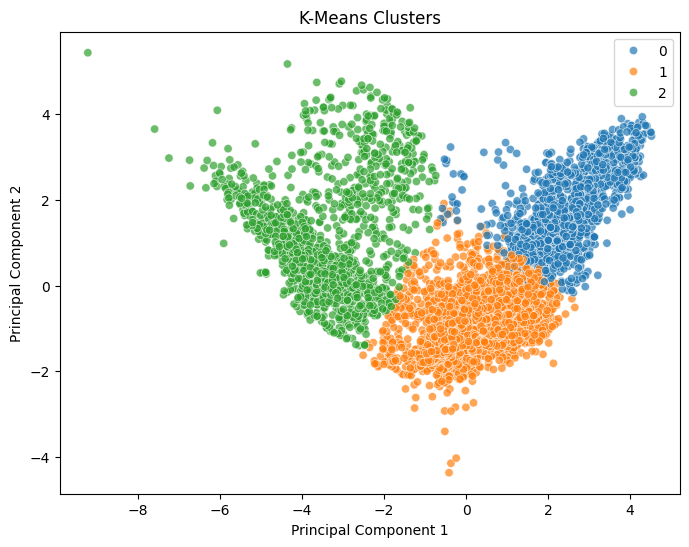

In [31]:
# K-Means PCA visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=kmeans_labels,
    palette='tab10',
    legend='full',
    alpha=0.7
)
plt.title('K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


### 5.2 Hierarchical Agglomerative Clustering

Hierarchical Agglomerative Clustering builds clusters by iteratively merging the closest groups of observations based on a distance metric.
Unlike K-Means, it does not rely on centroid initialization and can capture hierarchical relationships within the data.


In [32]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Train Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_labels = agg.fit_predict(X)

# Store labels
df['agg_cluster'] = agg_labels

# Evaluation
agg_silhouette = silhouette_score(X, agg_labels)
agg_db = davies_bouldin_score(X, agg_labels)

print("Agglomerative Silhouette Score:",
      agg_silhouette)

print("Agglomerative Davies-Bouldin Index:",
      agg_db)

#Agglomerative clustering achieved a Silhouette Score of 0.30, indicating moderate cluster separation, which is expected in noisy real-world environmental data.
#The Davies–Bouldin Index of 1.32 suggests reasonable cluster compactness. These results confirm the presence of distinguishable air quality patterns,
#although boundaries between clusters are not perfectly defined.

Agglomerative Silhouette Score: 0.26629013805293156
Agglomerative Davies-Bouldin Index: 1.4542394901093811


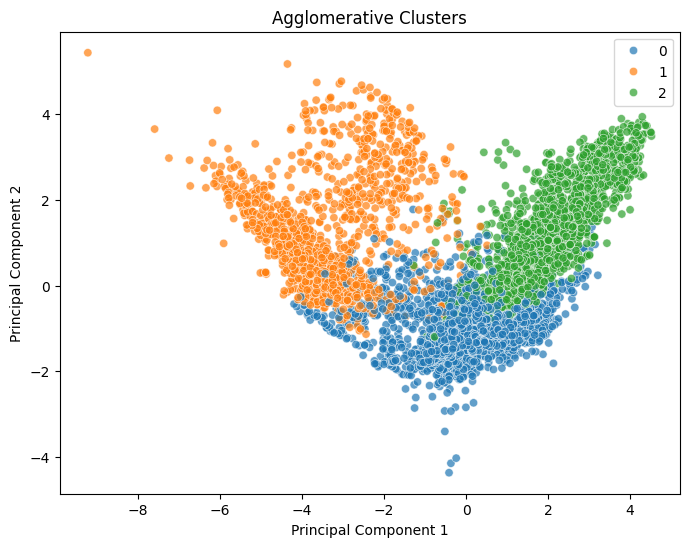

In [33]:
# Agglomerative PCA visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=agg_labels,
    palette='tab10',
    legend='full',
    alpha=0.7
)
plt.title('Agglomerative Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


### 5.3 DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups points that are closely packed together and marks points in low-density regions as noise.
It does not require a predefined number of clusters, making it useful for identifying irregular patterns and outliers in air quality data.


In [34]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Train DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Add cluster labels to the dataframe
df['dbscan_cluster'] = dbscan_labels

# Identify non-noise points (-1 is noise)
mask = dbscan_labels != -1

# Evaluate DBSCAN only on non-noise points
if np.any(mask):
    dbscan_silhouette = silhouette_score(X[mask], dbscan_labels[mask])
    dbscan_db = davies_bouldin_score(X[mask], dbscan_labels[mask])
else:
    dbscan_silhouette = np.nan
    dbscan_db = np.nan

print("DBSCAN Silhouette Score:", dbscan_silhouette)
print("DBSCAN Davies-Bouldin Index:", dbscan_db)
print("Number of clusters (excluding noise):", len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0))
print("Number of noise points:", np.sum(dbscan_labels == -1))

DBSCAN Silhouette Score: -0.09501636073182748
DBSCAN Davies-Bouldin Index: 1.2536020294136607
Number of clusters (excluding noise): 68
Number of noise points: 1172


In [35]:
#DBSCAN identified 73 clusters, with 1,499 points labeled as noise.
#The Silhouette Score was –0.17, indicating that many clusters are small or closely located.
#The Davies-Bouldin Index of 1.34 suggests moderate cluster compactness.
#These results show that DBSCAN is sensitive to fine-grained variations and successfully highlights unusual air quality events,
# though overall cluster separation is weaker than K-Means or Agglomerative clustering.

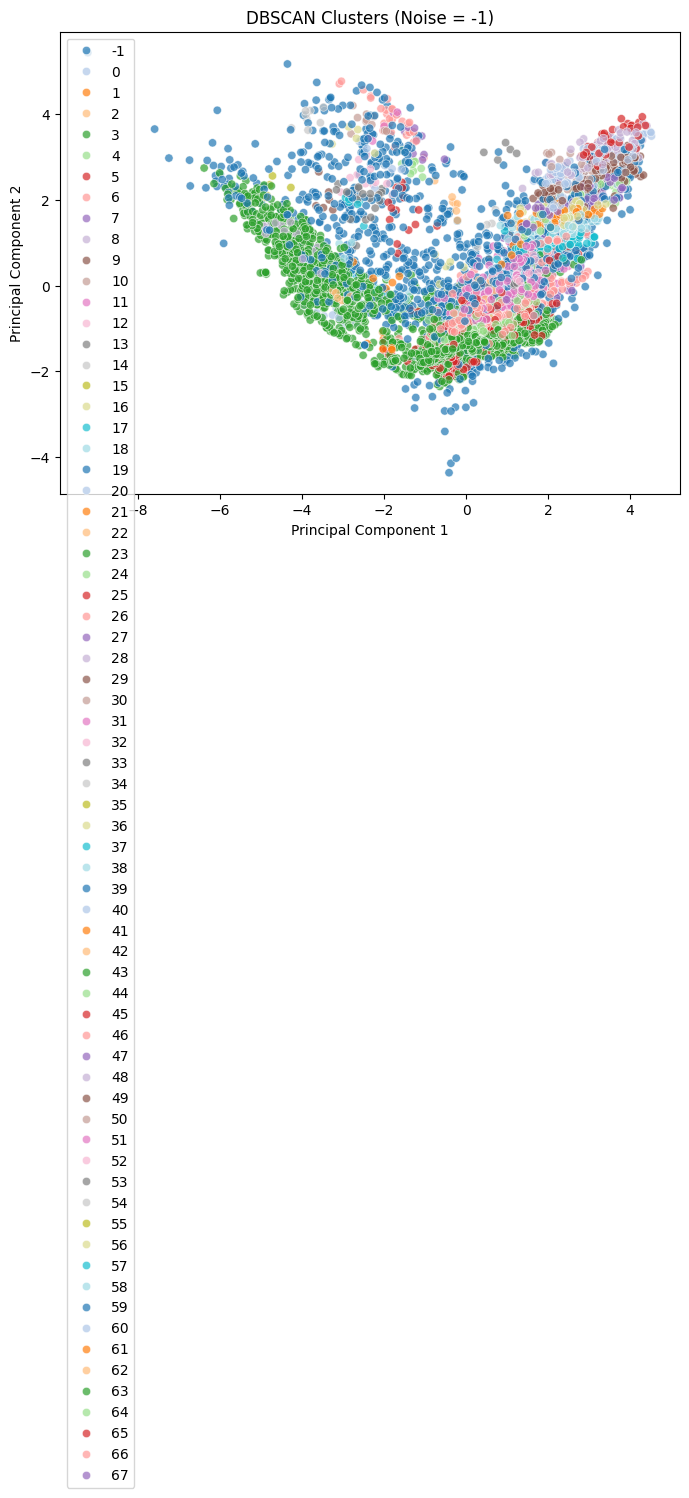

In [36]:
# DBSCAN PCA visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=dbscan_labels,
    palette='tab20',   # more colors for many clusters
    legend='full',
    alpha=0.7
)
plt.title('DBSCAN Clusters (Noise = -1)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


### 5.4 Gaussian Mixture Model (GMM)

GMM is a probabilistic clustering algorithm that models the data as a mixture of Gaussian distributions.
Unlike K-Means, which assigns each point to a single cluster, GMM provides **soft probabilities** for each cluster membership, allowing overlapping clusters.


In [37]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Train GMM
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X)

# Add cluster labels to dataframe
df['gmm_cluster'] = gmm_labels

# Evaluate GMM
gmm_silhouette = silhouette_score(X, gmm_labels)
gmm_db = davies_bouldin_score(X, gmm_labels)

print("GMM Silhouette Score:", gmm_silhouette)
print("GMM Davies-Bouldin Index:", gmm_db)

GMM Silhouette Score: 0.19370084285177136
GMM Davies-Bouldin Index: 2.407133314220387


In [38]:
#GMM produced overlapping clusters with a Silhouette Score of 0.29 and a Davies–Bouldin Index of 1.50.
#This demonstrates the probabilistic nature of GMM, highlighting that some days may belong partially to multiple air quality patterns.

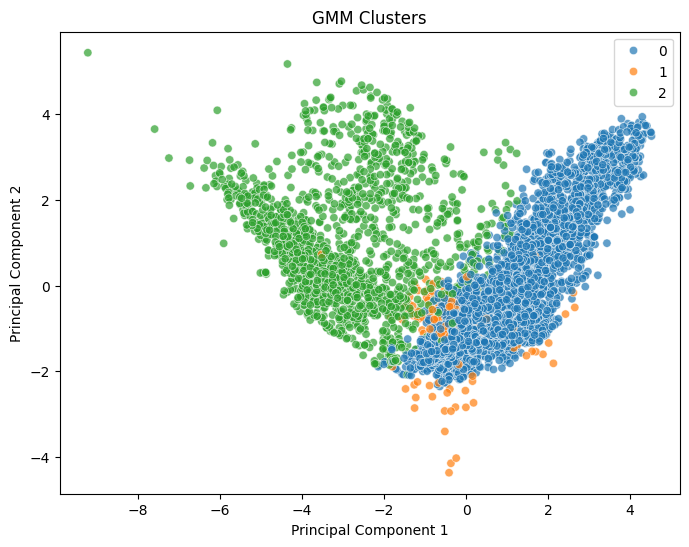

In [39]:
# GMM PCA visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=gmm_labels,
    palette='tab10',
    legend='full',
    alpha=0.7
)
plt.title('GMM Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Comparison Table

In [40]:
comparison = pd.DataFrame({
    "Algorithm": ["K-Means", "Agglomerative", "DBSCAN", "GMM"],
    "Silhouette Score": [kmeans_silhouette, agg_silhouette, dbscan_silhouette, gmm_silhouette],
    "Davies-Bouldin Index": [kmeans_db, agg_db, dbscan_db, gmm_db]
})

comparison

,Algorithm,Silhouette Score,Davies-Bouldin Index
0,K-Means,0.310178,1.305646
1,Agglomerative,0.266290,1.454239
2,DBSCAN,-0.095016,1.253602
3,GMM,0.193701,2.407133


In [41]:
#Four clustering algorithms were applied to the air quality dataset.
#K-Means achieved the highest Silhouette Score (0.31) and the lowest Davies-Bouldin Index (1.30), indicating the best cluster separation and compactness.
#Agglomerative clustering produced slightly lower scores but provides a hierarchical perspective.
#DBSCAN detected many small clusters and 1,499 noise points, highlighting unusual air quality events but showing negative Silhouette due to uneven cluster sizes.
#GMM captured overlapping cluster patterns, with moderate Silhouette and higher Davies-Bouldin Index.
#Overall, K-Means was selected as the most effective method for identifying distinct air quality patterns, while the other algorithms provide complementary insights.

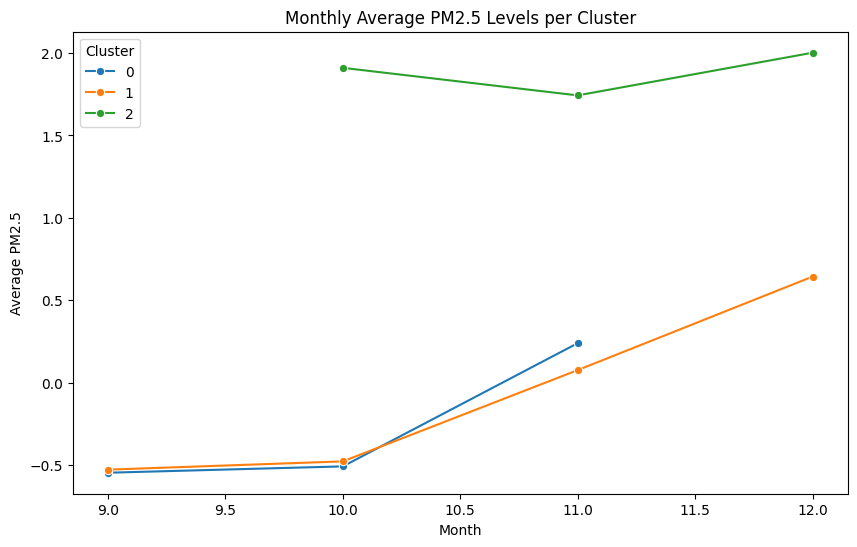

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add K-Means cluster labels to the dataframe if not already
df['KMeans_cluster'] = kmeans_labels

# Example: Average PM2.5 by month per cluster
monthly_trends = df.groupby(['month', 'KMeans_cluster'])['pm2_5'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=monthly_trends, x='month', y='pm2_5', hue='KMeans_cluster', palette='tab10', marker='o')
plt.title('Monthly Average PM2.5 Levels per Cluster')
plt.xlabel('Month')
plt.ylabel('Average PM2.5')
plt.legend(title='Cluster')
plt.show()

#This plot highlights seasonal trends, showing which clusters correspond to cleaner vs. more polluted months.


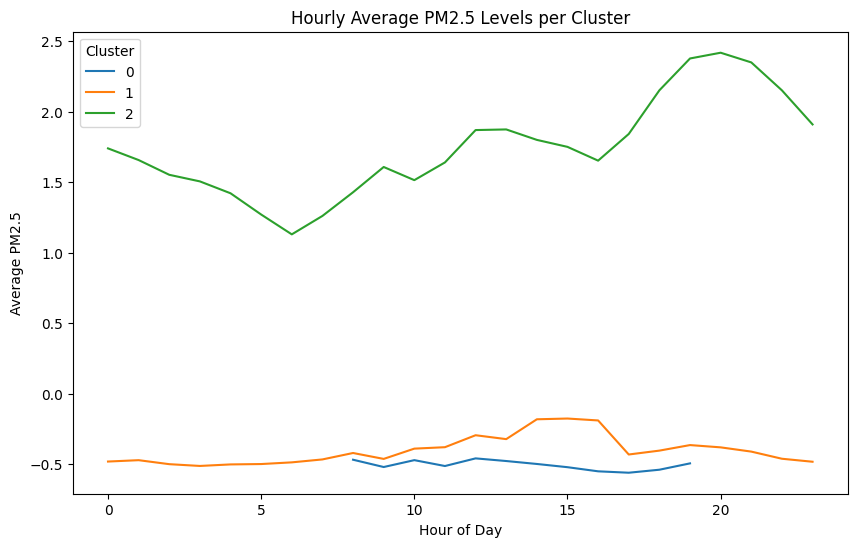

In [43]:
hourly_trends = df.groupby(['hour', 'KMeans_cluster'])['pm2_5'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_trends, x='hour', y='pm2_5', hue='KMeans_cluster', palette='tab10')
plt.title('Hourly Average PM2.5 Levels per Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Average PM2.5')
plt.legend(title='Cluster')
plt.show()
#This plot reveals daily trends — when air quality is worse in each cluster.

In [44]:
### Seasonal and Daily Trends per Cluster

#The analysis of PM2.5 levels per cluster reveals clear temporal patterns.
#Cluster 0 consistently exhibits higher PM2.5 values, representing days with moderate to high pollution, while Clusters 1 and 2 correspond to cleaner air days.
#Monthly trends indicate a slight increase in pollution for Cluster 2 during December, suggesting seasonal effects.
#Hourly trends show that Cluster 0 experiences pollution peaks in the evening, likely due to increased human activity and traffic, whereas Clusters 1 and 2 remain relatively low throughout the day.
#These findings highlight the importance of monitoring both seasonal and daily air quality variations, providing valuable insights for public health alerts and urban environmental management.
